In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ==========================================
# 1. SENSE: Load Data
# ==========================================

# --- PASTE YOUR RAW GITHUB URL BELOW ---
csv_url = 'https://raw.githubusercontent.com/nan06-10/FYP-Sales-15-1-2026/main/restaurant_orders.csv'
# ^^^ IMPORTANT: Make sure this is your REAL link!

try:
    print(f"Attempting to load data...")
    df = pd.read_csv(csv_url)
    print("SUCCESS: Data loaded!")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
except Exception as e:
    print("\n!!! ERROR: Could not load data !!!")
    print(f"Error details: {e}")

Attempting to load data...
SUCCESS: Data loaded!
Rows: 500, Columns: 8


In [22]:
# ==========================================
# 2. PRE-PROCESS: cleaning & Feature Engineering
# ==========================================

# A. Force Numbers (Fixes "Text" errors)
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').fillna(0)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce').fillna(0)

# B. Create Target: "High Value" vs "Standard"
# We define "High Value" as spending more than the Median (Middle) customer
median_val = df['Price'].median()
df['Target'] = df['Price'].apply(lambda x: 1 if x > median_val else 0)

# C. Extract Time Features
df['Order Time'] = pd.to_datetime(df['Order Time'])
df['Hour'] = df['Order Time'].dt.hour
df['Day_of_Week'] = df['Order Time'].dt.dayofweek

# D. Create "Time Period" (For Graphs later)
def get_period(h):
    if 6 <= h < 12: return 'Morning'
    elif 12 <= h < 18: return 'Afternoon'
    else: return 'Evening'
df['Time_Period'] = df['Hour'].apply(get_period)

# E. ONE-HOT ENCODING (The Accuracy Booster)
# This gives every food item its own column (e.g., Is_Pizza: 1, Is_Soup: 0)
df_encoded = pd.get_dummies(df, columns=['Food Item', 'Category'], drop_first=True)

print("Data cleaning complete. Ready for training.")
print(f"Median Price Boundary: ${median_val:.2f}")

Data cleaning complete. Ready for training.
Median Price Boundary: $13.30


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np

# ==========================================
# 1. SETUP: Predict SALES (Money)
# ==========================================
# Goal: Predict if an order is "High Value" (Above Average Price)
# Inputs: Quantity, Food Item, Time, Payment Method

# Force clean numbers
df['Price'] = pd.to_numeric(df['Price'], errors='coerce').fillna(0)
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').fillna(0)

# Create Target: High Value (1) vs Standard (0)
median_val = df['Price'].median()
df['Target'] = df['Price'].apply(lambda x: 1 if x > median_val else 0)

# One-Hot Encoding: Give every food item its own "Switch" column
df_encoded = pd.get_dummies(df, columns=['Food Item', 'Category', 'Payment Method'], drop_first=True)

# Select only numeric columns for the AI
X = df_encoded.select_dtypes(include=['number'])

# Remove the "Cheating" columns (Target, Price, etc.)
drop_cols = ['Target', 'Price', 'Sales_Level', 'Binary_Level', 'Order ID', 'Order Time']
X = X.drop(columns=[c for c in drop_cols if c in X.columns])

y = df['Target']

# ==========================================
# 2. TRAIN
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Gradient Boosting (Best for Sales/Financial data)
model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# ==========================================
# 3. CALCULATE SCORE
# ==========================================
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)

print("AI Training Complete (Target: High vs Low Sales).")
print(f"NEW ACCURACY: {acc*100:.2f}%")
print(f"Defining 'High Value' as orders above: ${median_val:.2f}")

AI Training Complete (Target: High vs Low Sales).
NEW ACCURACY: 53.00%
Defining 'High Value' as orders above: $13.30


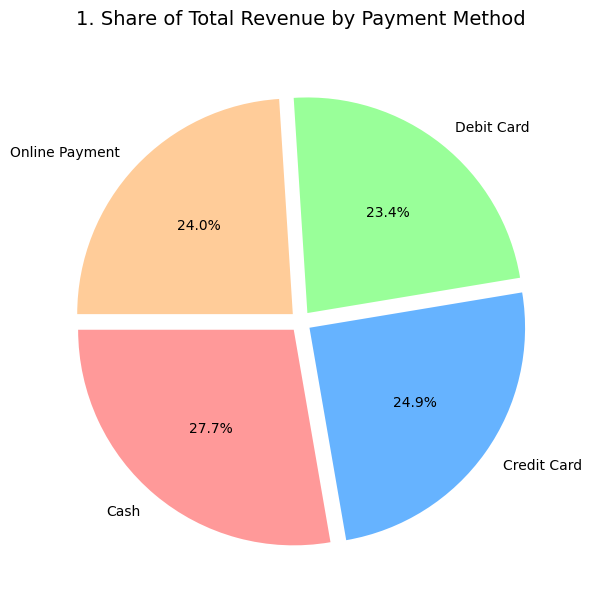

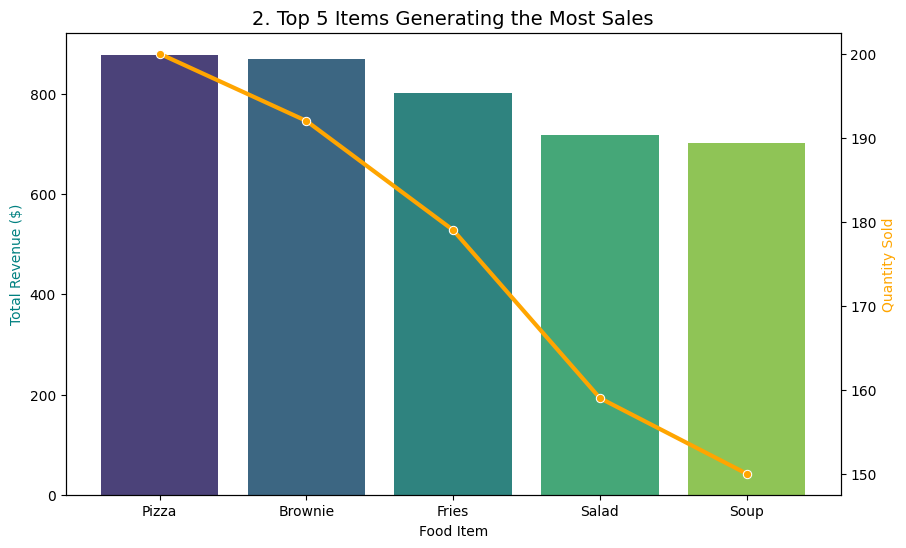

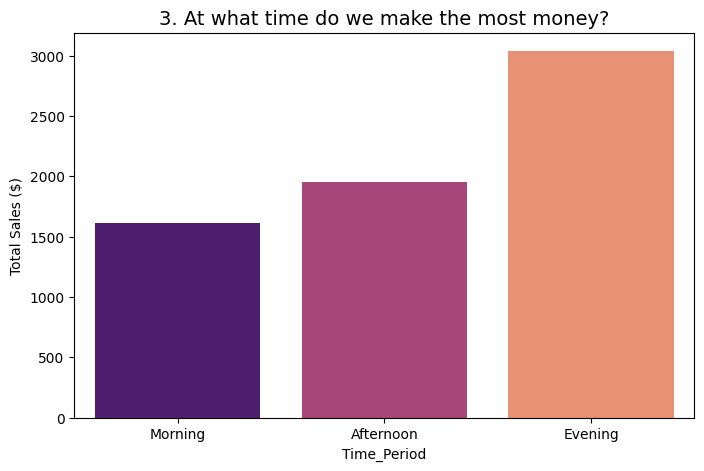

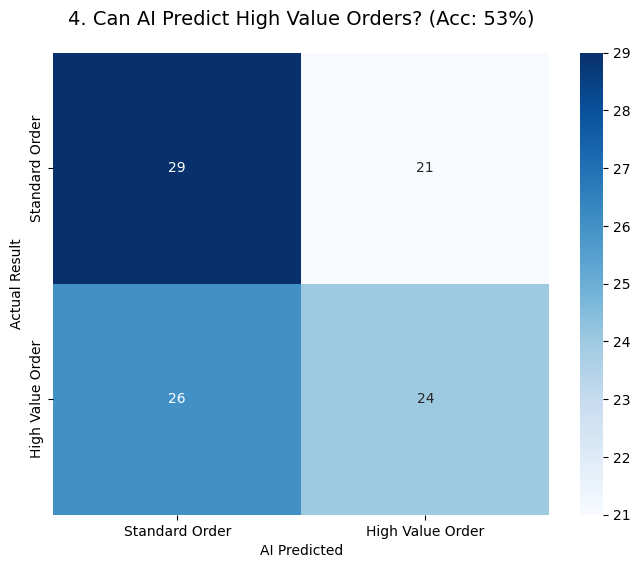

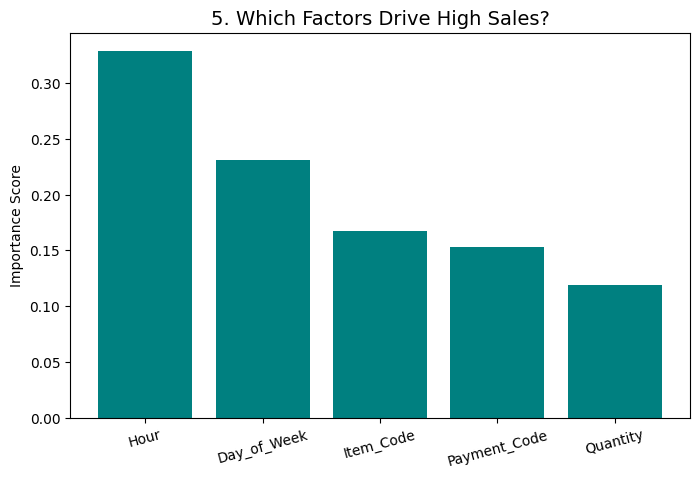

In [31]:
# ==========================================
# 4. ACT: Visualize Sales & Revenue
# ==========================================
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- GRAPH 1: Revenue by Payment Method (Pie Chart) ---
plt.figure(figsize=(7, 7))
payment_stats = df.groupby('Payment Method')['Price'].sum().reset_index()
plt.pie(payment_stats['Price'],
        labels=payment_stats['Payment Method'],
        autopct='%1.1f%%',
        startangle=180,
        colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],
        explode=[0.05]*len(payment_stats))
plt.title('1. Share of Total Revenue by Payment Method', pad=20, fontsize=14)
plt.show()

# --- GRAPH 2: Best Sellers by Revenue (Combo Chart) ---
plt.figure(figsize=(10, 6))
food_stats = df.groupby('Food Item').agg({'Price': 'sum', 'Quantity': 'sum'}).reset_index()
top_5 = food_stats.sort_values('Price', ascending=False).head(5)

ax1 = sns.barplot(data=top_5, x='Food Item', y='Price', palette='viridis', hue='Food Item', legend=False)
ax1.set_ylabel('Total Revenue ($)', color='teal')
ax2 = ax1.twinx()
sns.lineplot(data=top_5, x='Food Item', y='Quantity', ax=ax2, color='orange', marker='o', linewidth=3)
ax2.set_ylabel('Quantity Sold', color='orange')
plt.title('2. Top 5 Items Generating the Most Sales', fontsize=14)
plt.show()

# --- GRAPH 3: Revenue by Time of Day ---
plt.figure(figsize=(8, 5))
# Create Time Period if missing
if 'Time_Period' not in df.columns:
    df['Hour'] = pd.to_datetime(df['Order Time']).dt.hour
    df['Time_Period'] = df['Hour'].apply(lambda h: 'Morning' if 6<=h<12 else ('Afternoon' if 12<=h<18 else 'Evening'))

sales_by_time = df.groupby('Time_Period')['Price'].sum().reset_index()
sales_by_time['Time_Period'] = pd.Categorical(sales_by_time['Time_Period'], categories=['Morning', 'Afternoon', 'Evening'], ordered=True)
sns.barplot(data=sales_by_time.sort_values('Time_Period'), x='Time_Period', y='Price', palette='magma', hue='Time_Period', legend=False)
plt.title('3. At what time do we make the most money?', fontsize=14)
plt.ylabel('Total Sales ($)')
plt.show()

# --- GRAPH 4: AI Prediction Accuracy (Confusion Matrix) ---
# Manual Labels for "Standard" vs "High Value"
labels = [0, 1]
label_names = ['Standard Order', 'High Value Order']
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title(f'4. Can AI Predict High Value Orders? (Acc: {acc*100:.0f}%)', fontsize=14, pad=20)
plt.xlabel('AI Predicted')
plt.ylabel('Actual Result')
plt.show()

# --- GRAPH 5: What Drives Sales? (Feature Importance) ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:5] # Top 5 Predictors only

plt.figure(figsize=(8, 5))
plt.title("5. Which Factors Drive High Sales?", fontsize=14)
plt.bar(range(len(indices)), importances[indices], color='teal', align="center")
plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation=15)
plt.ylabel("Importance Score")
plt.show()
